In [11]:
import sys
from temgymbasic.model import (
    Model,
)
from temgymbasic import components as comp
import matplotlib.pyplot as plt
from PySide6.QtWidgets import QApplication
from temgymbasic.gui import TemGymWindow

import numpy as np
from temgymbasic.utils import calculate_phi_0
from temgymbasic import gbd

from typing import Tuple, NamedTuple
from temgymbasic.plotting import plot_model
import cupy as np
#%matplotlib widget

np.get_default_memory_pool().free_all_blocks()
np.get_default_pinned_memory_pool().free_all_blocks()


In [19]:
def zero_phase(u, idx_x, idx_y):
    u_centre = u[idx_x, idx_y]
    phase_difference =  0 - np.angle(u_centre)
    u = u * np.exp(1j * phase_difference)
    
    return u

def abssqr(x):
    return np.real(x*np.conj(x))

def FT(x):
    return np.fft.fftshift(np.fft.fft2(x))

def iFT(x):
    return np.fft.ifft2(np.fft.ifftshift(x))
    
def FresnelPropagator(E0, ps, lambda0, z):
    """
    Parameters:
        E0 : 2D array
            The initial complex field in the x-y source plane.
        ps : float
            Pixel size in the object plane (same units as wavelength).
        lambda0 : float
            Wavelength of the light (in the same units as ps).
        z : float
            Propagation distance (in the same units as ps).

    Returns:
        Ef : 2D array
            The complex field after propagating a distance z.
    """
    n, m = E0.shape

    fx = np.fft.fftfreq(n, ps)
    fy = np.fft.fftfreq(m, ps)
    Fx, Fy = np.meshgrid(fx, fy)
    
    H = np.exp(-1j * (2 * np.pi / lambda0) * z) * np.exp(-1j * np.pi * lambda0 * z * (Fx**2 + Fy**2))
    E0fft = np.fft.fft2(E0)
    G = H * E0fft
    Ef = np.fft.ifft2(G)
    
    return Ef

def LensMask(X, Y, lambda0, f):
    """
    Compute the phase factor introduced by an ideal lens.
    
    Parameters:
        n : int
            Number of pixels (assuming square grid, n x n).
        ps : float
            Pixel size (in the same units as wavelength and focal length).
        lambda0 : float
            Wavelength of the light (in the same units as ps).
        f : float
            focal length of the lens (in the same units as ps).
    
    Returns:
        phase_factor : 2D array (n x n)
            The phase factor to multiply with the field.
    """
    phase_factor = np.exp(-1j * np.pi * (X**2 + Y**2) / (lambda0 * f) + 1j * np.pi)
    
    return phase_factor


In [13]:
#Params
n_rays = 1000
wavelength = 0.0001
k = 2 * np.pi / wavelength

wavelengths = np.full(n_rays, wavelength)

size = 512
det_shape = (size, size)
pixel_size = 0.001

wo = 0.01
wos = np.full(n_rays, wo)

x0 = 0.03
y0 = 0

coeffs = [0.0, 0, 0.0, 0.0, 0]

In [14]:
components = [
    comp.GaussBeam(
        z=0.0,
        voltage=calculate_phi_0(wavelength),
        radius=x0,
        wo=wo,
    )
]

z_detector = 1.0
num_lenses = 50
focal_length = 1.0
z_lenses = np.linspace(0.1, z_detector, num_lenses, endpoint=False)
for i in range(num_lenses):
    components.append(
        comp.Lens(
            z=z_lenses[i],
            f=focal_length,
        )
    )


components.append(
    comp.AccumulatingDetector(
        z=z_detector,
        pixel_size=pixel_size,
        shape=det_shape,
        buffer_length=1,
        interference='gauss'
    )
)


In [15]:
model = Model(components)
rays = tuple(model.run_iter(num_rays=n_rays, random = False))
image = model.detector.get_image(rays[-1])

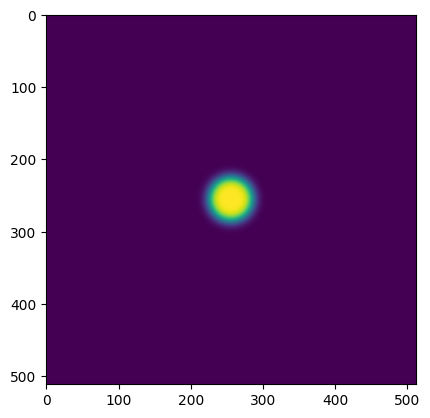

In [16]:
init_image = model.detector.get_image(rays[0])
plt.figure()
plt.imshow(init_image)

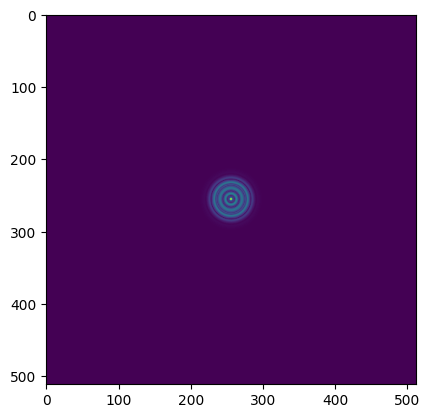

In [17]:
plt.figure()
plt.imshow(np.abs(image))

In [23]:

# np.get_default_memory_pool().free_all_blocks()
# np.get_default_pinned_memory_pool().free_all_blocks()

# size = 4096

image = init_image
x, y = np.meshgrid(np.linspace(-size/2, size/2, size), np.linspace(-size/2, size/2, size))

x = np.linspace(-size/2, size/2 - 1, size) * pixel_size
y = np.linspace(-size/2, size/2 - 1, size) * pixel_size
X, Y = np.meshgrid(x, y)

for i in range(1, len(model.components)):
    d = model.components[i].z - model.components[i-1].z
    image = FresnelPropagator(image, pixel_size, wavelength, d) 
    if isinstance(model.components[i], comp.Lens):
        image *= LensMask(X, Y, focal_length, wavelength)
    print(i)

# Propagate to the detector
d = z_detector - model.components[-1].z

image = FresnelPropagator(image, pixel_size, wavelength, d)
# image = np.asnumpy(image)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


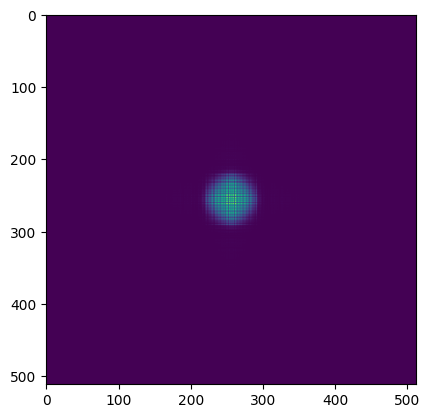

In [22]:
plt.figure()
plt.imshow(np.abs(image))